# Use Previous Block (DFR MLP)

In [113]:
import sys
import numpy as np
import torch
import torchvision
import einops
import json
import tqdm

from matplotlib import pyplot as plt

import sys
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [114]:
device = torch.device("cuda:4")

learning_rate = 0.1
num_epochs = 2000

nhd = [6, 7, 8, 9, 10, 11, 12, 16, 32, 64, 128]
num_seeds = 5

In [115]:
map_to_in9 = {}
with open('in_to_in9.json', 'r') as f:
    map_to_in9.update(json.load(f))

def load_embeddings(path):
    arr = np.load(path)
    x, y = arr["embeddings"], arr["labels"]
    if np.max(y) > 9:
        y = np.array([map_to_in9[str(y_)] for y_ in y])
        mask = y != -1
        x, y = x[mask], y[mask]
    return x, y

In [116]:
def train_logreg(
    x_train, y_train, eval_datasets, hidden_dim,
    n_epochs=1000, weight_decay=0., lr=1.,
    verbose=0,
    ):
    
    x_train = torch.from_numpy(x_train).float().to(device)
    y_train = torch.from_numpy(y_train).long().to(device)
    
    d = x_train.shape[1]

    model = torch.nn.Sequential(
        torch.nn.Linear(d, hidden_dim),  
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, 9)  
    ).to(device)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        model.parameters(), weight_decay=weight_decay, lr=lr)
    schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_epochs)
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        pred = model(x_train)
        loss = criterion(pred, y_train)
        loss.backward()
        optimizer.step()
        schedule.step()
        acc = (torch.argmax(pred, -1) == y_train).detach().float().mean()
        if verbose > 1 and epoch % (n_epochs // 10) == 0:
            print(epoch, acc)
    
    results = {}
    for key, (x_test, y_test) in eval_datasets.items():
        x_test = torch.from_numpy(x_test).float().to(device)
        pred = torch.argmax(model(x_test), axis=-1).detach().cpu().numpy()
        results[key] = (pred == y_test).mean()
    
    pred = torch.argmax(model(x_train), axis=-1)
    results["train"] = (pred == y_train).detach().cpu().float().mean().item()

    return model, results

def get_data(
    train_datasets, eval_datasets, 
    num_mixrand=-1, num_original=0, preprocess=True):
    
    x_train, y_train = train_datasets["bgc_original"]
    idx = np.arange(len(x_train))
    np.random.shuffle(idx)
    idx = idx[:num_original]
    x_train = x_train[idx]
    y_train = y_train[idx]

    x_train_mr, y_train_mr = train_datasets["bgc_mixedrand"]
    idx = np.arange(len(x_train_mr))
    np.random.shuffle(idx)
    idx = idx[:num_mixrand]
    x_train_mr = x_train_mr[idx]
    y_train_mr = y_train_mr[idx]

    x_train = np.concatenate([x_train, x_train_mr])
    y_train = np.concatenate([y_train, y_train_mr])

    if preprocess:
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        eval_datasets_preprocessed = {
            k: (scaler.transform(x), y)
            for k, (x, y) in eval_datasets.items()
        }
    else:
        eval_datasets_preprocessed = eval_datasets
    return x_train, y_train, eval_datasets_preprocessed


def run_experiment(
    train_datasets, eval_datasets, hidden_dim,
    num_mixrand=-1, num_original=0, preprocess=True,
    n_epochs=1000, weight_decay=0., lr=1., verbose=0,
    num_seeds=3
):
    results = {}
    for seed in range(num_seeds):
        x_train, y_train, eval_datasets_preprocessed = get_data(
            train_datasets, eval_datasets,
            num_mixrand, num_original, preprocess)
        _, results_seed = train_logreg(
            x_train, y_train, eval_datasets_preprocessed, hidden_dim,
            n_epochs, weight_decay, lr, verbose)
        results[seed] = results_seed
    
    results_aggrgated = {
        key: (np.mean([results[seed][key] for seed in results.keys()]),
              np.std([results[seed][key] for seed in results.keys()]))
        for key in results[0].keys()
    }
    return results, results_aggrgated


def print_results(results_dict):
    print("-------------------")
    for key, val in results_dict.items():
        print("{}: {:.3f}±{:.3f}".format(key, val[0], val[1]))
    print("-------------------")

In [117]:
def mixrand_run(nhd, n_epochs, lr, train_datasets, eval_datasets, num_seeds):
    mixrand_results_nhd = []
    for n in nhd:
        num_mixrand = 1000
        num_original = 0

        n_data = num_mixrand + num_original
        wd = 100 / n_data
        seed_results, results_aggrgated = run_experiment(
            train_datasets, eval_datasets, n,
            num_mixrand, num_original, lr=lr, weight_decay=wd, n_epochs=n_epochs,
            num_seeds=num_seeds)
        print_results(results_aggrgated)
        mixrand_results_nhd.append(results_aggrgated)
    return mixrand_results_nhd


def combo_run(nhd, n_epochs, lr, train_datasets, eval_datasets, num_seeds):
    combo_results_nhd = []
    for n in nhd:
        num_mixrand = 1000
        num_original = 1000

        n_data = num_mixrand + num_original
        wd = 100 / n_data
        seed_results, results_aggrgated = run_experiment(
            train_datasets, eval_datasets, n,
            num_mixrand, num_original, lr=lr, weight_decay=wd, n_epochs=n_epochs,
            num_seeds=num_seeds)
        print_results(results_aggrgated)
        combo_results_nhd.append(results_aggrgated)
    return combo_results_nhd

In [118]:
def plot_results_indv(key, ax, nhd, mixrand_results_nhd, combo_results_nhd):
    mixrand_mu = np.array([results[key][0] for results in mixrand_results_nhd])
    mixrand_sigma = np.array([results[key][1] for results in mixrand_results_nhd])

    combo_mu = np.array([results[key][0] for results in combo_results_nhd])
    combo_sigma = np.array([results[key][1] for results in combo_results_nhd])
    ax.plot(nhd, mixrand_mu, "-bo", label="DFR MR")
    ax.fill_between(nhd, mixrand_mu + mixrand_sigma, mixrand_mu - mixrand_sigma,
                   color="b", alpha=0.3)
    ax.plot(nhd, combo_mu, "-ro", label="DFR MR + Og")
    ax.fill_between(nhd, combo_mu + combo_sigma, combo_mu - combo_sigma,
                    color="r", alpha=0.3)
    
    ax.legend()
    ax.set_xlabel("Hidden Dim", fontsize=12)
    ax.set_ylabel(f"{key} Test Acc", fontsize=12)

def plot_all_results_indv(mixrand_results_nhd, combo_results_nhd):
    f, arr = plt.subplots(1, 5, figsize=(16, 3))

    plot_results_indv("bgc_mixedrand", arr[0], np.array(nhd), mixrand_results_nhd, combo_results_nhd)
    plot_results_indv("bgc_fg", arr[1], np.array(nhd), mixrand_results_nhd, combo_results_nhd)
    plot_results_indv("bgc_original", arr[2], np.array(nhd), mixrand_results_nhd, combo_results_nhd)
    plot_results_indv("imagenet_r", arr[3], np.array(nhd), mixrand_results_nhd, combo_results_nhd)
    plot_results_indv("imagenet_a", arr[4], np.array(nhd), mixrand_results_nhd, combo_results_nhd)

    plt.tight_layout()

## Original Network

In [119]:
use_prev_layer = False

eval_path_dict = {
    "imagenet_r": f"/home/jennyni/datasets/imagenet-r/imagenet-r_{use_prev_layer}_val_embeddings.npz",
    "imagenet_a": f"/home/jennyni/datasets/imagenet-a/imagenet-a_{use_prev_layer}_val_embeddings.npz",
    "bgc_original": f"/home/jennyni/datasets/bg_challenge/original/bg_challenge_{use_prev_layer}_val_embeddings.npz",
    "bgc_fg": f"/home/jennyni/datasets/bg_challenge/only_fg/bg_challenge_{use_prev_layer}_val_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/bg_challenge/mixed_rand/bg_challenge_{use_prev_layer}_val_embeddings.npz",
}

eval_datasets = {k: load_embeddings(p) for k, p in eval_path_dict.items()}

train_path_dict = {
    "bgc_original": f"/home/jennyni/datasets/original/bg_challenge_{use_prev_layer}_train_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/mixed_rand/bg_challenge_{use_prev_layer}_train_embeddings.npz",

}
train_datasets = {k: load_embeddings(p) for k, p in train_path_dict.items()}

In [120]:
# _, results_original_ori = run_experiment(train_datasets, eval_datasets,
#                                                 num_mixrand=0, num_original=-1, lr=learning_rate, num_seeds=num_seeds, n_epochs=num_epochs,
#                                                 weight_decay=100/45405)

# print_results(results_original_ori)

In [121]:
mixrand_results_nhd_ori = mixrand_run(nhd, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)
combo_results_nhd_ori = combo_run(nhd, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)

-------------------
imagenet_r: 0.454±0.018
imagenet_a: 0.277±0.021
bgc_original: 0.906±0.009
bgc_fg: 0.853±0.011
bgc_mixedrand: 0.817±0.008
train: 0.944±0.002
-------------------
-------------------
imagenet_r: 0.472±0.009
imagenet_a: 0.283±0.014
bgc_original: 0.917±0.011
bgc_fg: 0.866±0.010
bgc_mixedrand: 0.839±0.004
train: 0.964±0.005
-------------------
-------------------
imagenet_r: 0.492±0.008
imagenet_a: 0.282±0.023
bgc_original: 0.928±0.005
bgc_fg: 0.882±0.011
bgc_mixedrand: 0.854±0.004
train: 0.969±0.007
-------------------
-------------------
imagenet_r: 0.500±0.022
imagenet_a: 0.286±0.008
bgc_original: 0.940±0.004
bgc_fg: 0.901±0.005
bgc_mixedrand: 0.867±0.003
train: 0.974±0.004
-------------------
-------------------
imagenet_r: 0.517±0.003
imagenet_a: 0.295±0.011
bgc_original: 0.940±0.004
bgc_fg: 0.902±0.007
bgc_mixedrand: 0.868±0.005
train: 0.981±0.005
-------------------
-------------------
imagenet_r: 0.516±0.013
imagenet_a: 0.290±0.010
bgc_original: 0.944±0.003
bgc_fg

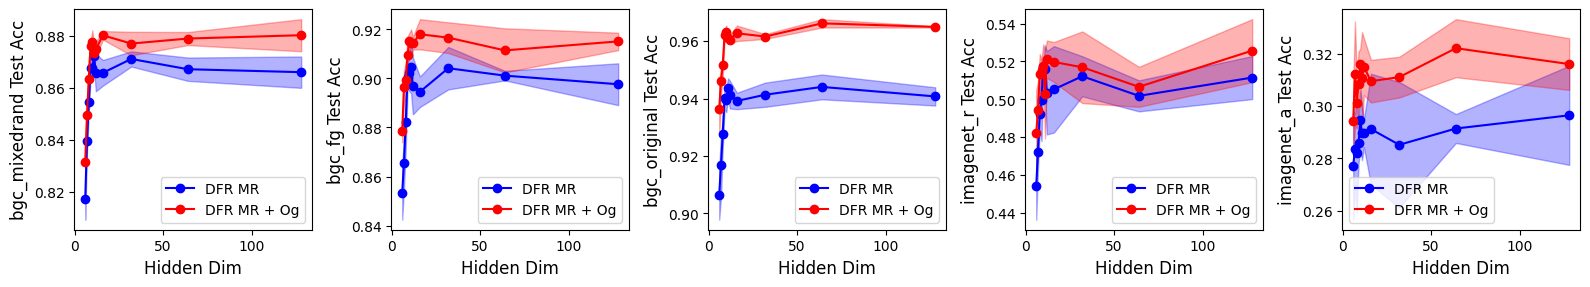

In [122]:
plot_all_results_indv(mixrand_results_nhd_ori, combo_results_nhd_ori)

## Using Representations before

In [123]:
use_prev_layer = True

eval_path_dict = {
    "imagenet_r": f"/home/jennyni/datasets/imagenet-r/new_imagenet-r_{use_prev_layer}_val_standardSL_embeddings.npz",
    "imagenet_a": f"/home/jennyni/datasets/imagenet-a/new_imagenet-a_{use_prev_layer}_val_standardSL_embeddings.npz",
    "bgc_original": f"/home/jennyni/datasets/bg_challenge/original/new_bg_challenge_{use_prev_layer}_val_standardSL_embeddings.npz",
    "bgc_fg": f"/home/jennyni/datasets/bg_challenge/only_fg/new_bg_challenge_{use_prev_layer}_val_standardSL_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/bg_challenge/mixed_rand/new_bg_challenge_{use_prev_layer}_val_standardSL_embeddings.npz",
}

eval_datasets = {k: load_embeddings(p) for k, p in eval_path_dict.items()}

train_path_dict = {
    "bgc_original": f"/home/jennyni/datasets/original/new_bg_challenge_{use_prev_layer}_train_standardSL_embeddings.npz",
    "bgc_mixedrand": f"/home/jennyni/datasets/mixed_rand/new_bg_challenge_{use_prev_layer}_train_standardSL_embeddings.npz",
}
train_datasets = {k: load_embeddings(p) for k, p in train_path_dict.items()}

In [124]:
# _, results_original_pre = run_experiment(train_datasets, eval_datasets,
#                                                 num_mixrand=0, num_original=-1, lr=learning_rate, num_seeds=num_seeds, n_epochs=num_epochs,
#                                                 weight_decay=100/45405)

# print_results(results_original_pre)

In [125]:
mixrand_results_nhd_pre = mixrand_run(nhd, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)
combo_results_nhd_pre = combo_run(nhd, n_epochs=num_epochs, lr=learning_rate, train_datasets=train_datasets, eval_datasets=eval_datasets, num_seeds=num_seeds)

-------------------
imagenet_r: 0.486±0.013
imagenet_a: 0.254±0.035
bgc_original: 0.846±0.012
bgc_fg: 0.818±0.009
bgc_mixedrand: 0.784±0.010
train: 0.893±0.015
-------------------
-------------------
imagenet_r: 0.482±0.014
imagenet_a: 0.259±0.014
bgc_original: 0.883±0.017
bgc_fg: 0.847±0.018
bgc_mixedrand: 0.811±0.015
train: 0.915±0.016
-------------------
-------------------
imagenet_r: 0.511±0.012
imagenet_a: 0.264±0.017
bgc_original: 0.904±0.004
bgc_fg: 0.877±0.005
bgc_mixedrand: 0.834±0.006
train: 0.949±0.003
-------------------
-------------------
imagenet_r: 0.515±0.007
imagenet_a: 0.278±0.008
bgc_original: 0.919±0.005
bgc_fg: 0.884±0.005
bgc_mixedrand: 0.856±0.005
train: 0.949±0.006
-------------------
-------------------
imagenet_r: 0.525±0.011
imagenet_a: 0.274±0.017
bgc_original: 0.927±0.002
bgc_fg: 0.896±0.006
bgc_mixedrand: 0.863±0.004
train: 0.957±0.004
-------------------
-------------------
imagenet_r: 0.531±0.010
imagenet_a: 0.284±0.011
bgc_original: 0.925±0.008
bgc_fg

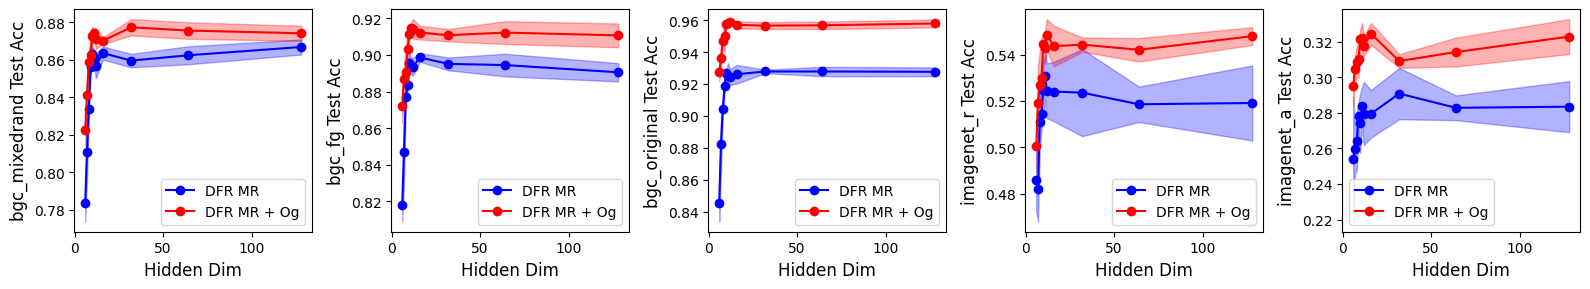

In [126]:
plot_all_results_indv(mixrand_results_nhd_pre, combo_results_nhd_pre)

## Out of Distribution Accuracy vs In Distribution Accuracy 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


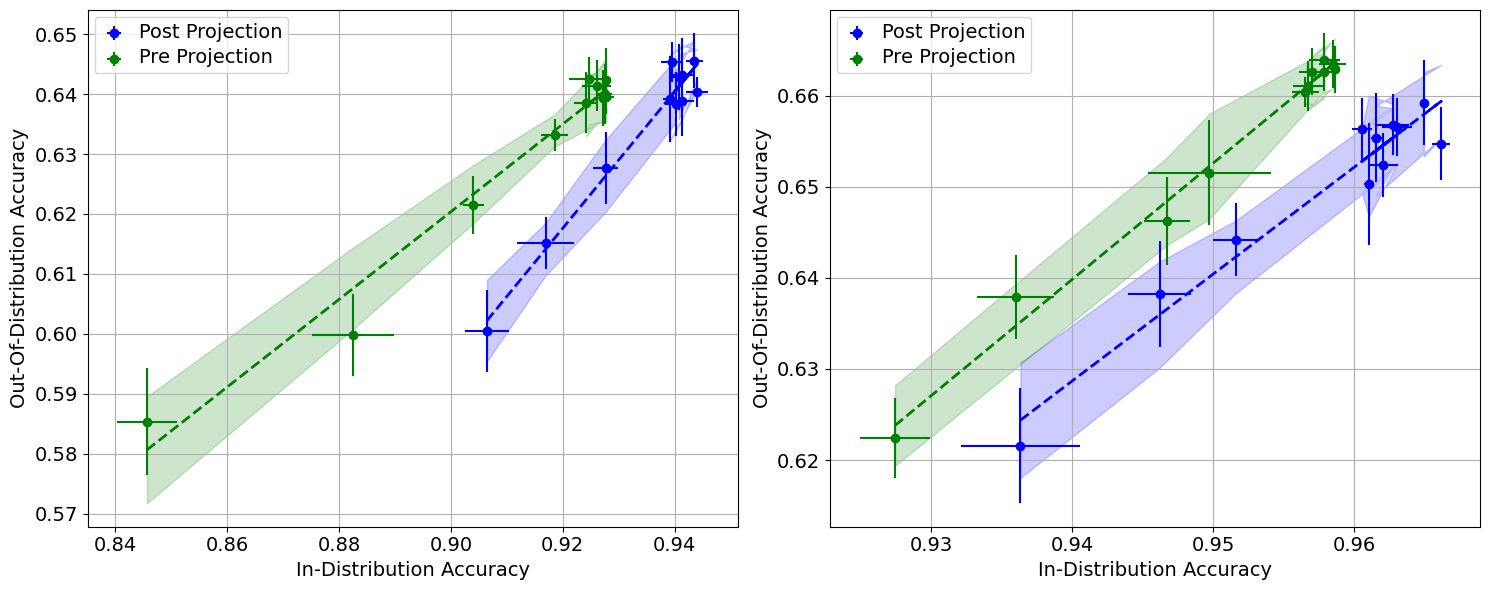

In [133]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def set_large_fonts(ax):
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.title.set_fontsize(16)
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)
    for item in ax.get_legend().get_texts():
        item.set_fontsize(14)

def process_results(results):
    in_distrib_acc = []
    out_distrib_acc = []
    in_distrib_std = []
    out_distrib_std = []
    
    for res in results:
        in_distrib_acc.append(res['bgc_original'][0])
        in_distrib_std.append(res['bgc_original'][1])
       
        out_distrib_means = [v[0] for k, v in res.items() if k != 'bgc_original' and k != 'train']
        out_distrib_stds = [v[1] for k, v in res.items() if k != 'bgc_original' and k != 'train']
        
        out_distrib_acc.append(np.mean(out_distrib_means))
        out_distrib_std.append(np.sqrt(np.mean(np.array(out_distrib_stds) ** 2)))  # Pooled standard deviation
        
    return in_distrib_acc, out_distrib_acc, in_distrib_std, out_distrib_std


def plot_results(in_acc, out_acc, in_std, out_std, label, color, n=5, ax=None):
    in_err = np.array(in_std) / np.sqrt(n)
    out_err = np.array(out_std) / np.sqrt(n)

    if ax is None:
        ax = plt.gca() 

    ax.errorbar(in_acc, out_acc, xerr=in_err, yerr=out_err, fmt='o', label=label, color=color)
    slope, intercept, _, _, _ = stats.linregress(in_acc, out_acc)
    in_acc_line = np.array(in_acc)
    out_acc_line = slope * in_acc_line + intercept

    ax.plot(in_acc_line, out_acc_line, '--', lw=2, color=color)
    ax.fill_between(in_acc_line, out_acc_line - out_err, out_acc_line + out_err, alpha=0.2, color=color)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))  

in_original, out_original, in_std_original, out_std_original = process_results(mixrand_results_nhd_ori)
in_pre, out_pre, in_std_pre, out_std_pre = process_results(mixrand_results_nhd_pre)
# axs[0].set_title('MR In vs Out-Of-Distribution Accuracy')
plot_results(in_original, out_original, in_std_original, out_std_original, 'Post Projection', 'blue', ax=axs[0])
plot_results(in_pre, out_pre, in_std_pre, out_std_pre, 'Pre Projection', 'green', ax=axs[0])

in_original, out_original, in_std_original, out_std_original = process_results(combo_results_nhd_ori)
in_pre, out_pre, in_std_pre, out_std_pre = process_results(combo_results_nhd_pre)
# axs[1].set_title('MR + OG In vs Out-Of-Distribution Accuracy')
plot_results(in_original, out_original, in_std_original, out_std_original, 'Post Projection', 'blue', ax=axs[1])
plot_results(in_pre, out_pre, in_std_pre, out_std_pre, 'Pre Projection', 'green', ax=axs[1])

for ax in axs:
    ax.set_xlabel('In-Distribution Accuracy')
    ax.set_ylabel('Out-Of-Distribution Accuracy')
    ax.legend()
    ax.grid(True)
    set_large_fonts(ax)


plt.tight_layout()

plt.show()

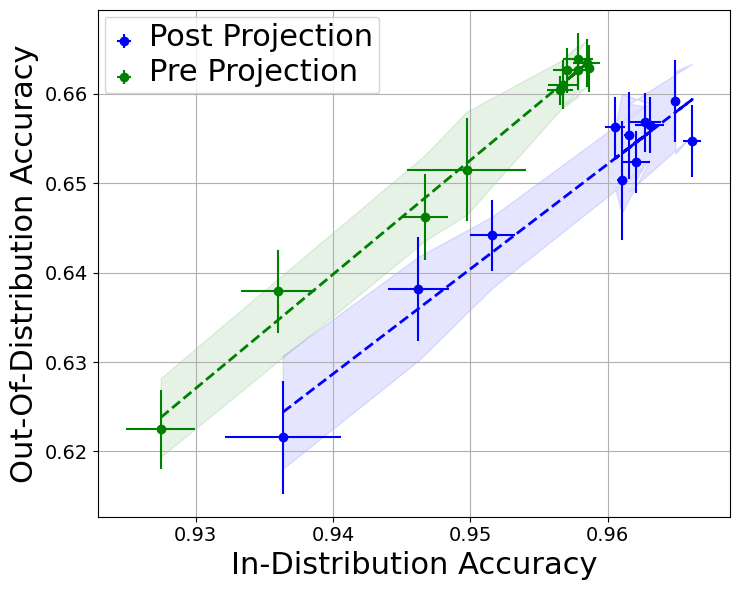

In [144]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def set_large_fonts(ax):
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.title.set_fontsize(22)
    ax.xaxis.label.set_fontsize(22)
    ax.yaxis.label.set_fontsize(22)
    for item in ax.get_legend().get_texts():
        item.set_fontsize(22)

def process_results(results):
    in_distrib_acc = []
    out_distrib_acc = []
    in_distrib_std = []
    out_distrib_std = []
    
    for res in results:
        in_distrib_acc.append(res['bgc_original'][0])
        in_distrib_std.append(res['bgc_original'][1])
        
        out_distrib_means = [v[0] for k, v in res.items() if k != 'bgc_original' and k != 'train']
        out_distrib_stds = [v[1] for k, v in res.items() if k != 'bgc_original' and k != 'train']
        
        out_distrib_acc.append(np.mean(out_distrib_means))
        out_distrib_std.append(np.sqrt(np.mean(np.array(out_distrib_stds) ** 2)))  # Pooled standard deviation
        
    return in_distrib_acc, out_distrib_acc, in_distrib_std, out_distrib_std


def plot_results(in_acc, out_acc, in_std, out_std, label, color, n=5, ax=None):
    in_err = np.array(in_std) / np.sqrt(n)
    out_err = np.array(out_std) / np.sqrt(n)

    if ax is None:
        ax = plt.gca() 

    ax.errorbar(in_acc, out_acc, xerr=in_err, yerr=out_err, fmt='o', label=label, color=color)
    slope, intercept, _, _, _ = stats.linregress(in_acc, out_acc)
    in_acc_line = np.array(in_acc)
    out_acc_line = slope * in_acc_line + intercept

    ax.plot(in_acc_line, out_acc_line, '--', lw=2, color=color)
    ax.fill_between(in_acc_line, out_acc_line - out_err, out_acc_line + out_err, alpha=0.1, color=color)

fig, axs = plt.subplots(1, 1, figsize=(7.5, 6))  

in_original, out_original, in_std_original, out_std_original = process_results(combo_results_nhd_ori)
in_pre, out_pre, in_std_pre, out_std_pre = process_results(combo_results_nhd_pre)

plot_results(in_original, out_original, in_std_original, out_std_original, 'Post Projection', 'blue', ax=axs)
plot_results(in_pre, out_pre, in_std_pre, out_std_pre, 'Pre Projection', 'green', ax=axs)

axs.set_xlabel('In-Distribution Accuracy')
axs.set_ylabel('Out-Of-Distribution Accuracy')
axs.legend()
axs.grid(True)
set_large_fonts(axs)

plt.tight_layout()
plt.savefig('prev_layer.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()
